In [1]:
# ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# Verify you're in the right place
!pwd
!ls -la

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Pintu-Air
total 27492
-rw------- 1 root root 5517847 Jun 11 14:58 '01 Result Data Cleaning Part 1.csv'
-rw------- 1 root root 2009870 Jun 13 22:15 '02 All Data.csv'
-rw------- 1 root root 1964974 Jun 11 14:58 '02 Data Preperation.ipynb'
-rw------- 1 root root  256098 Jun 11 14:58 '02 X_test.csv'
-rw------- 1 root root 4831129 Jun 11 14:58 '02 X_train.csv'
-rw------- 1 root root   40580 Jun 11 14:58 '02 y_test.csv'
-rw------- 1 root root  770651 Jun 11 14:58 '02 y_train.csv'
-rw------- 1 root root  322748 Jun 11 14:58 '03 ARIMA.ipynb'
-rw------- 1 root root    2277 Jun 11 14:58  03_Result_ARIMA.csv
-rw------- 1 root root 6247212 Jun 11 14:58  04c_ARIMA_Manggarai.ipynb
-rw------- 1 root root  631448 Jun 11 14:58  06_DataPreperation_ML.ipynb
-rw------- 1 root root 1611961 Jun 11 14:58  07a_best_model.keras
-rw------- 1 root root  365926 Jun 13 23:17  07a_LSTM_Manggarai.ipynb
-rw------- 1 root root 1685693 Jun 11 14:58  07b_best_model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# GPU Configuration
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
y_train = (pd.read_csv("02 y_train.csv", index_col='Tanggal')).values
y_test = (pd.read_csv("02 y_test.csv", index_col='Tanggal')).values

In [5]:
X = pd.read_csv("02 All Data.csv")
X['Tanggal'] = pd.to_datetime( X['Tanggal'])
X = X.set_index('Tanggal')
X = X.iloc[24:] # to keep the number of data the same as other model

# One-hot encode all cuaca columns and drop 'Terang' column
categorical_col = [col for col in X.columns if 'cuaca' in col]
numeric_col = [col for col in X.columns if 'air' in col]

X_cat = pd.concat([X[col] for col in categorical_col], axis=1)
X_num = pd.concat([X[col] for col in numeric_col], axis=1)

columns_to_drop = []

X_cat['hour_sin'] = np.sin(2 * np.pi * X.index.hour / 24)
X_cat['hour_cos'] = np.cos(2 * np.pi * X.index.hour / 24)

for cuaca_col in categorical_col:
    # Create a new binary column for 'Hujan' or 'Gerimis'
    X_cat[f'{cuaca_col}_hujan'] = X_cat[cuaca_col].isin(['Hujan', 'Gerimis'])
    # Add the original 'cuaca' column to the list of columns to be dropped
    columns_to_drop.append(cuaca_col)

# Drop the original string-based 'cuaca' columns
X_cat = X_cat.drop(columns=columns_to_drop)

In [6]:
# Seperate train and test data
split_index = int(len(X) * 0.95)

X_num_train = X_num[:split_index]
X_num_test = X_num[split_index:]

X_cat_train = X_cat[:split_index]
X_cat_test = X_cat[split_index:]

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_num_train_scaled = scaler_X.fit_transform(X_num_train)
X_num_test_scaled = scaler_X.transform(X_num_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# Combine scaled continuous with unscaled binary features
X_train = np.concatenate([X_num_train_scaled, X_cat_train], axis=1)
X_test = np.concatenate([X_num_test_scaled, X_cat_test], axis=1)

print(f"\n{'='*60}\nData Train and Test Distribution:\n{'='*60}")

print(f'Jumlah data: {len(X)}')

print(f'Jumlah data X train: {len(X_num_train)}')
print(f'Jumlah data X test: {len(X_num_test)}')

print(f'Jumlah data y train: {len(y_train)}')
print(f'Jumlah data y test: {len(y_test)}')



Data Train and Test Distribution:
Jumlah data: 31200
Jumlah data X train: 29640
Jumlah data X test: 1560
Jumlah data y train: 29640
Jumlah data y test: 1560


In [7]:
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []

    for i in range(sequence_length, len(X)):
        # Take sequence_length previous time steps as features
        X_seq.append(X[i-sequence_length:i])
        # Current time step as target
        y_seq.append(y[i])

    return np.array(X_seq), np.array(y_seq)

In [8]:
# Create sequences
SEQUENCE_LENGTH = 24

X_seq, y_seq = create_sequences(X_train, y_train_scaled, SEQUENCE_LENGTH)
print(f"Sequence features shape: {X_seq.shape}")
print(f"Sequence target shape: {y_seq.shape}")

Sequence features shape: (29616, 24, 8)
Sequence target shape: (29616,)


In [9]:
# Build LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X_seq.shape[2])),
    Dropout(0.2),

    LSTM(64, return_sequences=True),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)
])

In [10]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,513 (517.63 KB)

 Trainable params: 132,513 (517.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [13]:
# Train the model
history = model.fit(
    X_seq, y_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

ValueError: Invalid dtype: object

# Data WITHOUT weather

In [ ]:
# Create new dataframe for lagged features
lagged_data = pd.DataFrame(index=df.index)

# Target variable (current Manggarai and 1 hour back)
lagged_data['Manggarai'] = df['Manggarai (air)']

# Cross-correlation lags for Depok (8 hours back)
lagged_data['Depok Lag 8'] = df['Depok (air)'].shift(8)

# Cross-correlation lags for Katulampa (12 hours back)
lagged_data['Katulampa Lag 12'] = df['Katulampa (air)'].shift(12)

# Check for missing values (due to shifting)
print(lagged_data.head())
print(f'\nLagged Data Shape: {lagged_data.shape}\n')
print('Missing values due to shifting:')
print(lagged_data.isnull().sum())

# Remove rows with missing values (caused by lagging)
lagged_data = lagged_data.dropna()
print(f"\nAfter removing missing values: {lagged_data.shape}")
lagged_data.head()

                     Manggarai  Depok Lag 8  Katulampa Lag 12
Tanggal                                                      
2021-10-16 00:00:00      555.0          NaN               NaN
2021-10-16 01:00:00      555.0          NaN               NaN
2021-10-16 02:00:00      555.0          NaN               NaN
2021-10-16 03:00:00      555.0          NaN               NaN
2021-10-16 04:00:00      560.0          NaN               NaN

Lagged Data Shape: (31224, 3)

Missing values due to shifting:
Manggarai            0
Depok Lag 8          8
Katulampa Lag 12    12
dtype: int64

After removing missing values: (31212, 3)


,Manggarai,Depok Lag 8,Katulampa Lag 12
Tanggal,,,
2021-10-16 12:00:00,570.0,90.0,10.0
2021-10-16 13:00:00,570.0,85.0,10.0
2021-10-16 14:00:00,570.0,85.0,10.0
2021-10-16 15:00:00,570.0,85.0,10.0
2021-10-16 16:00:00,570.0,80.0,10.0


In [ ]:
# Separate features and target
feature_columns = [col for col in lagged_data.columns]
X = lagged_data[feature_columns].values
y = lagged_data['Manggarai'].values

In [ ]:
# Seperate train and test data
split_index = int(len(lagged_data) * 0.95)

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X[:split_index]
X_test = X[split_index:]

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

print(f"\n{'='*60}\nData Train and Test Distribution:\n{'='*60}")
print(f'Jumlah data: {len(lagged_data)}')
print(f'Jumlah data train: {len(y_train)}')
print(f'Jumlah data test: {len(y_test)}')



Data Train and Test Distribution:
Jumlah data: 31212
Jumlah data train: 29651
Jumlah data test: 1561


In [ ]:
print('X Before Scaling:')
print(X_train)

print(f'\nX After Scaling:')
print(X_train_scaled)

print(f'\ny Before Scaling:')
print(y_train)

print(f'\ny After Scaling:')
print(y_train_scaled)

X Before Scaling:
[[570.  90.  10.]
 [570.  85.  10.]
 [570.  85.  10.]
 ...
 [830. 225.  90.]
 [825. 225.  90.]
 [815. 215.  90.]]

X After Scaling:
[[0.66666667 0.20716113 0.0052356 ]
 [0.66666667 0.1943734  0.0052356 ]
 [0.66666667 0.1943734  0.0052356 ]
 ...
 [0.97619048 0.55242967 0.42408377]
 [0.9702381  0.55242967 0.42408377]
 [0.95833333 0.52685422 0.42408377]]

y Before Scaling:
[570. 570. 570. ... 830. 825. 815.]

y After Scaling:
[0.66666667 0.66666667 0.66666667 ... 0.97619048 0.9702381  0.95833333]


In [ ]:
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []

    for i in range(sequence_length, len(X)):
        # Take sequence_length previous time steps as features
        X_seq.append(X[i-sequence_length:i])
        # Current time step as target
        y_seq.append(y[i])

    return np.array(X_seq), np.array(y_seq)

In [ ]:
# Create sequences
SEQUENCE_LENGTH = 24

X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
print(f"Sequence features shape: {X_seq.shape}")
print(f"Sequence target shape: {y_seq.shape}")

Sequence features shape: (29627, 24, 3)
Sequence target shape: (29627,)


In [ ]:
print(X_seq[3])

[[0.66666667 0.1943734  0.0052356 ]
 [0.66666667 0.18158568 0.0052356 ]
 [0.66666667 0.18158568 0.0052356 ]
 [0.66666667 0.18158568 0.0052356 ]
 [0.68452381 0.18158568 0.0052356 ]
 [0.70238095 0.18158568 0.0052356 ]
 [0.66071429 0.18158568 0.0052356 ]
 [0.66071429 0.18158568 0.0052356 ]
 [0.66071429 0.18158568 0.0052356 ]
 [0.69047619 0.18158568 0.0052356 ]
 [0.67261905 0.18158568 0.0052356 ]
 [0.66666667 0.18158568 0.0052356 ]
 [0.66071429 0.18158568 0.0052356 ]
 [0.6547619  0.18158568 0.0052356 ]
 [0.6547619  0.1943734  0.0052356 ]
 [0.6547619  0.1943734  0.0052356 ]
 [0.64880952 0.1943734  0.0052356 ]
 [0.6547619  0.18158568 0.0052356 ]
 [0.6547619  0.18158568 0.0052356 ]
 [0.6547619  0.18158568 0.0052356 ]
 [0.6547619  0.18158568 0.0052356 ]
 [0.6547619  0.18158568 0.05759162]
 [0.6547619  0.1943734  0.05759162]
 [0.66071429 0.21994885 0.0052356 ]]


In [ ]:
print(y_seq[3])

0.6666666666666667


In [ ]:
y_seq[0:3]

array([0.6547619 , 0.6547619 , 0.66071429])

In [ ]:
y_seq[3]

np.float64(0.6666666666666667)

In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X_seq.shape[2])),
    Dropout(0.2),

    LSTM(64, return_sequences=True),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)
])

I0000 00:00:1749297999.401750  108410 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [ ]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,953 (507.63 KB)

 Trainable params: 129,953 (507.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [ ]:
# Train the model
history = model.fit(
    X_seq, y_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1749298125.955697  111877 cuda_dnn.cc:529] Loaded cuDNN version 90300


741/741 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.0187 - mae: 0.0823 - val_loss: 0.0031 - val_mae: 0.0460 - learning_rate: 0.0010
Epoch 2/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0020 - mae: 0.0308 - val_loss: 0.0029 - val_mae: 0.0449 - learning_rate: 0.0010
Epoch 3/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.0012 - mae: 0.0221 - val_loss: 0.0020 - val_mae: 0.0353 - learning_rate: 0.0010
Epoch 4/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 9.4552e-04 - mae: 0.0184 - val_loss: 0.0013 - val_mae: 0.0228 - learning_rate: 0.0010
Epoch 5/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 7.9874e-04 - mae: 0.0161 - val_loss: 0.0011 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 6/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 7.2376e-04 - mae: 0.0150 - val_loss: 0.0013 - val_mae: 0.0243 - learning_rate: 0.0010
Epoch 7/100
741/741 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 6.8232e-04 - mae: 0.0144 - val_loss: 9.5900e-04 - val_mae: 0.0148 -

In [ ]:
model.save("07_best_model.keras")

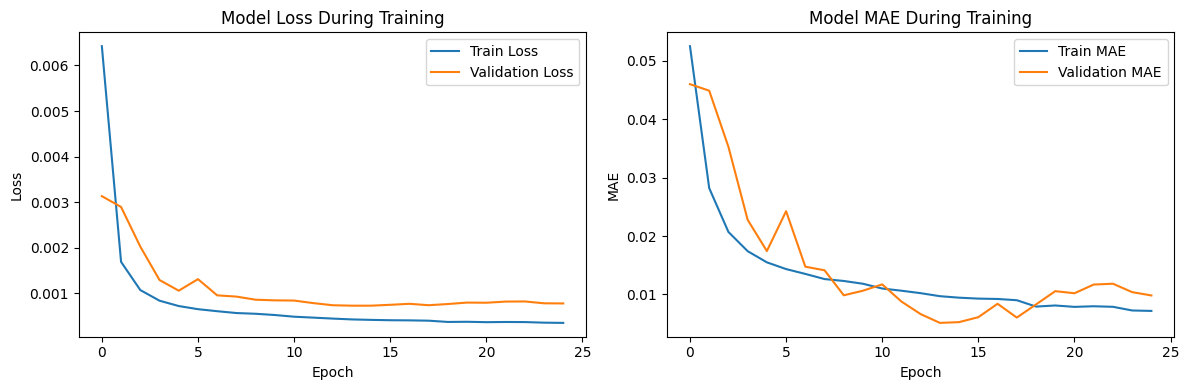

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prepare test data
X_test_scaled = scaler_X.transform(X_test)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH)

print(f"\nTest sequence shape: {X_test_seq.shape}")
print(f"Test target shape: {y_test_seq.shape}")

# Make predictions on test set
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

# Calculate MAPE (Mean Absolute Percentage Error)
# Avoid division by zero
mask = y_test_seq != 0
mape = np.mean(np.abs((y_test_seq[mask] - y_pred.flatten()[mask]) / y_test_seq[mask])) * 100

print(f"\n{'='*60}\nModel Performance on Test Set:\n{'='*60}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Test sequence shape: (1537, 24, 3)
Test target shape: (1537,)
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Model Performance on Test Set:
RMSE: 24.3491
MAE: 5.1045
R² Score: 0.2477
MAPE: 2.03%


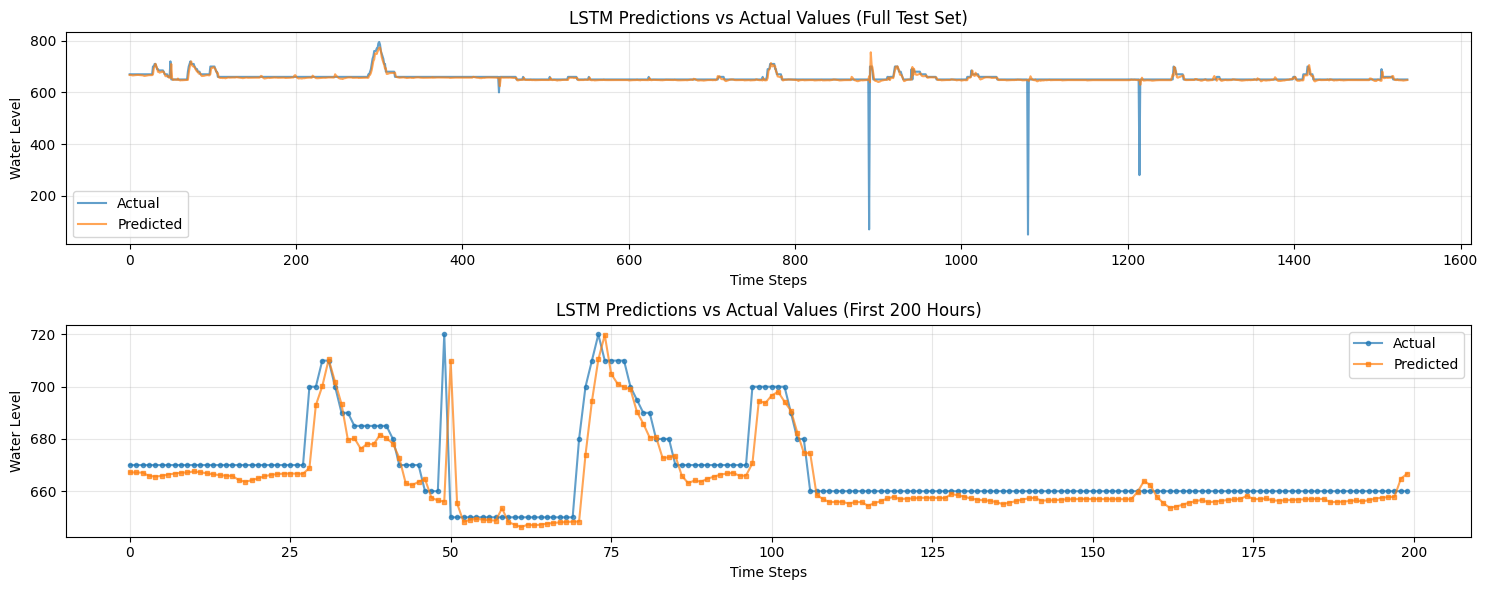

In [ ]:
# Visualize predictions vs actual
plt.figure(figsize=(15, 6))

# Plot 1: Full test set predictions
plt.subplot(2, 1, 1)
plt.plot(y_test_seq, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('LSTM Predictions vs Actual Values (Full Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Water Level')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoomed view (first 200 hours)
plt.subplot(2, 1, 2)
zoom_length = min(200, len(y_test_seq))
plt.plot(y_test_seq[:zoom_length], label='Actual', marker='o', markersize=3, alpha=0.7)
plt.plot(y_pred[:zoom_length], label='Predicted', marker='s', markersize=3, alpha=0.7)
plt.title('LSTM Predictions vs Actual Values (First 200 Hours)')
plt.xlabel('Time Steps')
plt.ylabel('Water Level')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

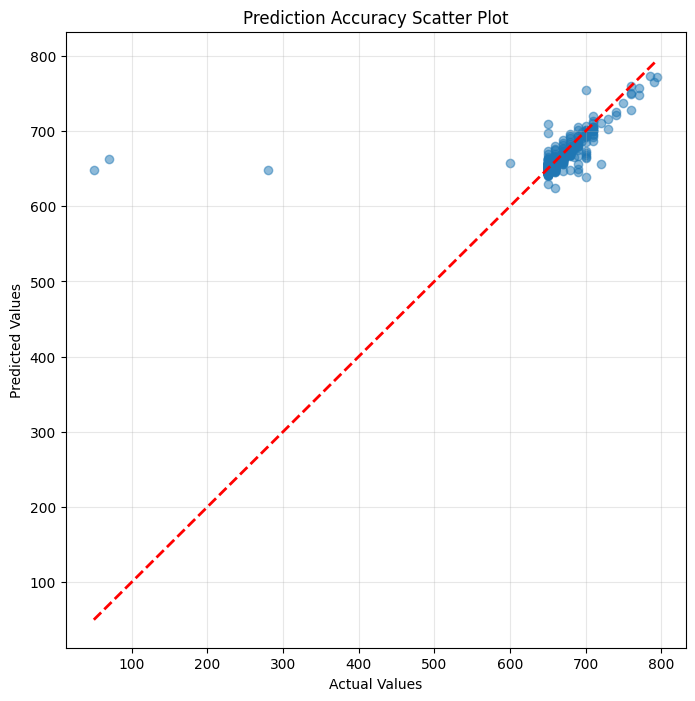

In [ ]:
# Create scatter plot for prediction accuracy
plt.figure(figsize=(8, 8))
plt.scatter(y_test_seq, y_pred, alpha=0.5)
plt.plot([y_test_seq.min(), y_test_seq.max()],
         [y_test_seq.min(), y_test_seq.max()],
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction Accuracy Scatter Plot')
plt.grid(True, alpha=0.3)
plt.show()

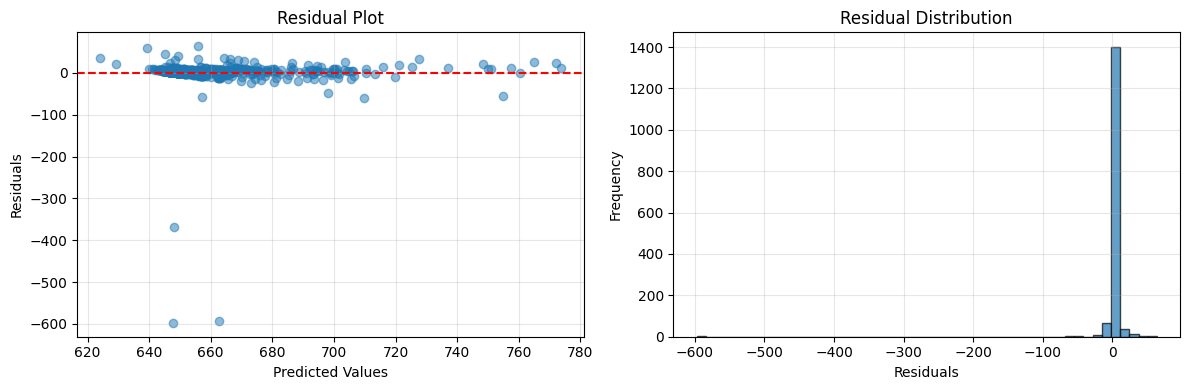


Sample Predictions (First 10):
Actual: 670.00, Predicted: 667.22, Error: 2.78
Actual: 670.00, Predicted: 667.18, Error: 2.82
Actual: 670.00, Predicted: 667.10, Error: 2.90
Actual: 670.00, Predicted: 665.87, Error: 4.13
Actual: 670.00, Predicted: 665.60, Error: 4.40
Actual: 670.00, Predicted: 665.85, Error: 4.15
Actual: 670.00, Predicted: 666.38, Error: 3.62
Actual: 670.00, Predicted: 666.75, Error: 3.25
Actual: 670.00, Predicted: 667.05, Error: 2.95
Actual: 670.00, Predicted: 667.18, Error: 2.82


In [ ]:
# Residual analysis
residuals = y_test_seq - y_pred.flatten()

plt.figure(figsize=(12, 4))

# Residual plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# Residual histogram
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print sample predictions
print(f"\n{'='*60}\nSample Predictions (First 10):\n{'='*60}")
for i in range(min(10, len(y_test_seq))):
    print(f"Actual: {y_test_seq[i]:.2f}, Predicted: {y_pred[i][0]:.2f}, "
          f"Error: {abs(y_test_seq[i] - y_pred[i][0]):.2f}")